# Kinshasa Floods, December 13th 2022

In [ ]:
"""Kinshasa Floods, December 13 2022
Authors: Elvira Cheng & Rayne Davidson
GISC412"""

'Kinshasa Floods, December 13 2022\nAuthors: Elvira Cheng & Rayne Davidson\nGISC412'

## Install and Imports

In [ ]:
!pip install -q pysheds
!pip install -q rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 944.3 kB/s eta 0:00:00


In [ ]:
import rioxarray as rxr
import pandas as pd
import matplotlib.cm as cm
from scipy.ndimage import zoom
from scipy import ndimage
from pysheds.grid import Grid # this can take a while to import
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import numpy as np
import pyproj
import warnings
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.features import geometry_mask
from affine import Affine
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

import geemap
# Turn on interactive view on ee objects
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=waAsMeRfGYJOOIzvtN5smi1ZeCCm8KnGH35sPvZwLQ8&tc=gixYgrrpo0SPptol4yoDFqI3J03CC9c-e8vM0XiHpAI&cc=41byQtY8uF4n1T8dFTI5ANMnFfEugfhAfDzrGb3l80M

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXkQInRfDskqA0n0ZDvwifc4_SSO20IcmuBF1qmCXXoSNMZ0vqVYVYU

Successfully saved authorization token.


In [ ]:
# you will need to mount your google drive to download and access the data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set areas of interest

In [ ]:
# Creating an EE polygon for the greater Kinshasa area (overview)
dr_congo = ee.Geometry.Polygon(
    [[[15.02291, -4.65430],
      [15.02291, -3.88652],
      [15.75374, -3.88652],
      [15.75374, -4.65430],
      ]]
    )

# Creating an EE polygon for Kinshasa
kinshasa = ee.Geometry.Polygon([
    [15.16696, -4.40049],
    [15.16696, -4.19645],
    [15.37276, -4.19645],
    [15.37261, -4.40049]
    ])

# Creating a non-EE polygon for Kinshasa
kinshasa_polygon = Polygon([
    (15.16696, -4.40049),
    (15.16696, -4.19645),
    (15.37276, -4.19645),
    (15.37261, -4.40049)
    ])

## Satellite imagery processing

### Set filters

In [ ]:
# Set start and end dates of a period BEFORE the flood
before_start = '2022-12-08'
before_end = '2022-12-12'

# Set start and end dates of a period AFTER the flood
after_start = '2022-12-14'
after_end = '2022-12-20'

# polarization and pass direction determined from sentinel-1 documentation

polarization = 'VV'
pass_direction = 'DESCENDING'

### Read SAR data & preprocess

In [ ]:
SAR_collection= (ee.ImageCollection('COPERNICUS/S1_GRD')\
  .filter(ee.Filter.eq('instrumentMode','IW'))\
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
  .filter(ee.Filter.eq('orbitProperties_pass',pass_direction))\
  .filter(ee.Filter.eq('resolution_meters',10))
  .filterBounds(dr_congo)
  .select(polarization))

In [ ]:
# filter by date

SAR_before_collection = SAR_collection.filterDate(before_start, before_end)
SAR_after_collection = SAR_collection.filterDate(after_start,after_end)

# mosaic and clip to AOI
SAR_before_mosaic = SAR_before_collection.mosaic().clip(dr_congo)
SAR_after_mosaic = SAR_after_collection.mosaic().clip(dr_congo)

# Apply reduce the radar speckle by smoothing
smoothing_radius = 80

SAR_before = SAR_before_mosaic.focal_mean(smoothing_radius, 'circle', 'meters')
SAR_after = SAR_after_mosaic.focal_mean(smoothing_radius, 'circle', 'meters')

### Creating the SAR Flood Extent (Difference Image)

In [ ]:
# Calculate the difference between the before and after images

SAR_difference = SAR_after.divide(SAR_before)

SAR_difference_threshold = 1.25 # this is a parameter we can mess around with and change to see if we can get better results
SAR_dif_binary = SAR_difference.gt(SAR_difference_threshold)

## Pysheds

In [ ]:
# import DEM and clip to the area
DRC_DEM=ee.Image("USGS/SRTMGL1_003").clip(dr_congo)

In [ ]:
# exports DEM to pwd so we can read it in as a raster (not EE object)

geemap.ee_export_image(DRC_DEM, filename='dem.tif')

Generating URL ...
Please wait ...
Data downloaded to /content/dem.tif


In [ ]:
# read the DEM into pyshed

pysh_grid = Grid.from_raster("dem.tif")
pysh_dem = pysh_grid.read_raster("dem.tif")

### DEM pre-processing for pysheds

Most of this processing was taken from the Pysheds HAND tutorial: http://mattbartos.com/pysheds/hand.html

In [ ]:
# this was from the pysheds HAND tutorial

# Detect pits
pits = pysh_grid.detect_pits(pysh_dem)

# Fill pits
pit_filled_dem = pysh_grid.fill_pits(pysh_dem)
pits = pysh_grid.detect_pits(pit_filled_dem)
assert not pits.any()

# Detect depressions
depressions = pysh_grid.detect_depressions(pit_filled_dem)

# Fill depressions
flooded_dem = pysh_grid.fill_depressions(pit_filled_dem)
depressions = pysh_grid.detect_depressions(flooded_dem)
assert not depressions.any()

# Detect flats
flats = pysh_grid.detect_flats(flooded_dem)

inflated_dem = pysh_grid.resolve_flats(flooded_dem)
flats = pysh_grid.detect_flats(inflated_dem)
assert not flats.any()

In [ ]:
# this was from the pysheds HAND tutorial

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
fdir = pysh_grid.flowdir(inflated_dem, dirmap=dirmap)

# Compute flow accumulation based on computed flow direction
accumulation = pysh_grid.accumulation(fdir)

In [ ]:
# finding the elevation range of our area so we can scale it to the tutorial's elevation threshold

min_elevation = np.nanmin(inflated_dem)
max_elevation = np.nanmax(inflated_dem)
elevation_range = max_elevation - min_elevation

In [ ]:
# scaling our HAND inundation threshold to the threshold (3) used in pysheds tutorial
# as it relates to the range of elevation pysheds tutorial catchment (103)
tutorial_elev_range = 103
tutorial_elev_thresh = 3

max_elevation = np.nanmax(inflated_dem)
min_elevation = np.nanmin(inflated_dem)
elevation_range = max_elevation - min_elevation


elevation_threshold = elevation_range * (tutorial_elev_thresh/tutorial_elev_range)

# this elevation threshold is too high for our purpose, lets find a middle ground
elevation_threshold = int(elevation_threshold)-5

In [ ]:
# scaling our accumulation threshold to the threshold (200) used in pysheds tutorial
# as it relates to how many pixels are in pysheds tutorial catchment (26720)

tutorial_pixel_count = 26720
tutorial_acc_thresh = 200


# original 1:1 scale from the tutorial was finding approximately 1/3 the flooded area as was found in SAR
# so we modified our accumulation threshold to attempt to allign the flooded area in the model with the
# observed flooded area from SAR (so we divided by 3)

accumulation_threshold = (int(accumulation.size * (tutorial_acc_thresh/tutorial_pixel_count)))  / 3

### HAND Inundation Extent

In [ ]:
# Compute height above nearest drainage
HAND = pysh_grid.compute_hand(fdir, pysh_dem, accumulation > accumulation_threshold)

# Create a view of HAND in the catchment
HAND_view = pysh_grid.view(HAND, nodata=np.nan)

# inundation extent within defined thresholds
pysh_inundation_extent = np.where(HAND_view < elevation_threshold, elevation_threshold - HAND_view, np.nan)

## JRC surface water Masking

### SAR Masking

In [ ]:
# Create the mask for permanant water

swater = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').clip(dr_congo).select('seasonality') # 30 m resolution
swater_mask = swater.gte(10).updateMask(swater.gte(10))

SAR_flooded_mask = SAR_dif_binary.where(swater_mask, 0)
SAR_masked_flooded = SAR_flooded_mask.updateMask(SAR_flooded_mask)

# Compute connectivity of pixels to eliminate those connected to 8 or fewer neighbours
# This operation reduces noise of the flood extent product

SAR_connections = SAR_masked_flooded.connectedPixelCount()
SAR_flooded = SAR_masked_flooded.updateMask(SAR_connections.gte(8))

In [ ]:
# Preparing for flooded area calculation

DRC_DEM=ee.Image("USGS/SRTMGL1_003").clip(dr_congo)
terrain = ee.Algorithms.Terrain(DRC_DEM)
slope = terrain.select('slope')


SAR_flooded = SAR_flooded.updateMask(slope.lt(5));

### pyshed mask

In [ ]:
# export seasonal water mask to pwd

geemap.ee_export_image(swater_mask, filename='swater_mask.tif')

Generating URL ...
Please wait ...
Data downloaded to /content/swater_mask.tif


In [ ]:
# read in season water mask as array

swater_np = plt.imread("swater_mask.tif")

In [ ]:
# minimum meters of inundation to be considered
inundation_threshold = pysh_inundation_extent > 0


# Calculate the required scaling factors for each dimension
y_scale = swater_np.shape[0] / inundation_threshold.shape[0]
x_scale = swater_np.shape[1] / inundation_threshold.shape[1]

# Resize flood_initial to match the shape of swater_np
flood_initial_resized = zoom(inundation_threshold, (y_scale, x_scale))

# 2. Masking perennial water bodies with 0 value
pysh_flooded_mask = np.where(swater_np, 0, flood_initial_resized)

# 3. Computing pixel connectivity and filtering pixels connected to 8 or fewer neighbors.
# Define a structure for 8-connectivity
structure = [[1,1,1],
             [1,1,1],
             [1,1,1]]


# Count the number of connected pixels
connected_count = ndimage.convolve(pysh_flooded_mask.astype(int), structure, mode='constant', cval=0)

# Filter pixels connected to 8 or fewer neighbours
pysh_masked_flooded = np.where(connected_count >= 0, pysh_flooded_mask, 0)

## Calc flooded area

### SAR Kinshasa flooded area
- regular river is masked out, ROI clipped to Kinshasa

In [ ]:
kinshasa_SAR_flood_pixelarea = SAR_flooded.select(polarization)\
  .multiply(ee.Image.pixelArea())

kinshasa_SAR_flood_stats = (kinshasa_SAR_flood_pixelarea.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': kinshasa,
  'scale': 10, # native resolution
  'bestEffort': True})
)

# Convert the flood extent to hectares (area calculations are originally given in meters)
kinshasa_SAR_flood_area_ha = kinshasa_SAR_flood_stats\
  .getNumber(polarization)\
  .divide(10000)\
  .round()

print("Estimated SAR flood extent:", str(kinshasa_SAR_flood_area_ha.getInfo()) + " hectares")

Estimated SAR flood extent: 8878 hectares


### Pyshed Kinshasa modeled flooded area
- regular river is masked out, ROI clipped to Kinshasa

In [ ]:
# clipping modeled flood area array to just kinshasa

width, height = pysh_masked_flooded.shape[0], pysh_masked_flooded.shape[1]

west = pysh_grid.affine.c
north = pysh_grid.affine.f
east = west + pysh_grid.affine.a * width
south = north + pysh_grid.affine.e * height

transform = rio.transform.from_bounds(
    west, south, east, north,
    pysh_masked_flooded.shape[1],
    pysh_masked_flooded.shape[0])

# Create a mask from the polygon
kinshasa_mask = geometry_mask([kinshasa_polygon],
                     transform=transform, invert=True,
                     out_shape=pysh_masked_flooded.shape)

pysh_kinshasa_masked = pysh_masked_flooded * kinshasa_mask.astype(int)


In [ ]:
 # Assuming each pixel is 30m x 30m defined by dem
pyshed_pixel_area_m2 = 30 * 30
pyshed_pixel_area_hectares = pyshed_pixel_area_m2 * 0.0001

# Count the number of flooded pixels
pyshed_flooded_pixel_count = np.sum(pysh_kinshasa_masked)

# Calculate total flooded area in hectares
pyshed_total_flooded_area_hectares = pyshed_flooded_pixel_count * pyshed_pixel_area_hectares

print(f"Estimated Pyshed Flooded Area: {pyshed_total_flooded_area_hectares:.2f} hectares")

Estimated Pyshed Flooded Area: 5129.82 hectares


## Maps

### Greater Kinshasa Area (Overview)

Download the SAR Flood extents

In [ ]:
# export SAR image of flooded areas so it can be
# plotted with matplotlib

def task_export(image, description, region):
  """exports ee image with scale 10 crs 4326"""

  # Initialize an Earth Engine batch export task
  # Create an export task using Export.image.toDrive
  task = ee.batch.Export.image.toDrive(
      image=image,
      description=description,
      region=region,
      scale=10,
      crs='EPSG:4326'
  )

  task.start()


In [ ]:
# exporting SAR image of flooded areas so it can be
# plotted with matplotlib

task_export(SAR_flooded, "SAR_flooded", dr_congo)

In [ ]:
# exporting SAR image of just kinshasa's flooded areas
# so it can be plotted with matplotlib

task_export(SAR_flooded.clip(kinshasa), "ksh_SAR_flooded", kinshasa)

The tasks can take a while to download, but they need to download before any of the maps can be created. The **first** Population density code can be run while it downloads though

https://code.earthengine.google.com/

#### Population Density (Open Buildings)
This can take a little while to run

**Open Buildings Dataset Preparation**
From the sample notebook provided at https://sites.research.google/open-buildings/

Copyright 2021 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

Open Buildings - spatial analysis examples

This notebook demonstrates some analysis methods with [Open Buildings](https://sites.research.google/open-buildings/) data:

* Generating heatmaps of building density and size.
* A simple analysis of accessibility to health facilities.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

Download buildings data for a region in Africa [takes up to 15 minutes for large countries]

In [ ]:
#@markdown Select a region from either the [Natural Earth low res](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) (fastest), [Natural Earth high res](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) or [World Bank high res](https://datacatalog.worldbank.org/dataset/world-bank-official-boundaries) shapefiles:
region_border_source = 'Natural Earth (High Res 10m)'  #@param ["Natural Earth (Low Res 110m)", "Natural Earth (High Res 10m)", "World Bank (High Res 10m)"]
region = ''  #@param ["", "AGO (Angola)", "BDI (Burundi)", "BEN (Benin)", "BFA (Burkina Faso)", "BGD (Bangladesh)", "BRN (Brunei)", "BTN (Bhutan)", "BWA (Botswana)", "CAF (Central African Republic)", "CIV (C\u00f4te d'Ivoire)", "CMR (Cameroon)", "COD (Democratic Republic of the Congo)", "COG (Republic of the Congo)", "COM (Comoros)", "CPV (Cape Verde)", "DJI (Djibouti)", "DZA (Algeria)", "EGY (Egypt)", "ERI (Eritrea)", "ETH (Ethiopia)", "GAB (Gabon)", "GHA (Ghana)", "GIN (Guinea)", "GMB (The Gambia)", "GNB (Guinea-Bissau)", "GNQ (Equatorial Guinea)", "IDN (Indonesia)", "IOT (British Indian Ocean Territory)", "KEN (Kenya)", "KHM (Cambodia)", "LAO (Laos)", "LBR (Liberia)", "LKA (Sri Lanka)", "LSO (Lesotho)", "MDG (Madagascar)", "MDV (Maldives)", "MOZ (Mozambique)", "MRT (Mauritania)", "MUS (Mauritius)", "MWI (Malawi)", "MYS (Malaysia)", "MYT (Mayotte)", "NAM (Namibia)", "NER (Niger)", "NGA (Nigeria)", "NPL (Nepal)", "PHL (Philippines)", "REU (R\u00e9union)", "RWA (Rwanda)", "SDN (Sudan)", "SEN (Senegal)", "SGP (Singapore)", "SHN (Saint Helena, Ascension and Tristan da Cunha)", "SLE (Sierra Leone)", "SOM (Somalia)", "STP (S\u00e3o Tom\u00e9 and Pr\u00edncipe)", "SWZ (Eswatini)", "SYC (Seychelles)", "TGO (Togo)", "THA (Thailand)", "TLS (Timor-Leste)", "TUN (Tunisia)", "TZA (Tanzania)", "UGA (Uganda)", "VNM (Vietnam)", "ZAF (South Africa)", "ZMB (Zambia)", "ZWE (Zimbabwe)"]

#@markdown Alternatively, specify an area of interest in [WKT format](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (assumes crs='EPSG:4326'); this [tool](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) might be useful.
your_own_wkt_polygon = 'POLYGON((15.41823 -3.88675, 15.02317 -4.27671, 15.32770 -4.65416, 15.75363 -4.21720, 15.41823 -3.88675))'  #@param {type:"string"}
#@markdown Select type of data to download here:
data_type = 'points'  #@param ["polygons", "points"]
#@markdown In this analysis we only need centroids of buildings, therefore by default we use the data in the *point* format (files in *polygons* format are larger). Refer to [Open Buildings Data Format](https://sites.research.google/open-buildings/#dataformat) for more details.
!sudo apt-get install swig
!pip install -q s2geometry pygeos geopandas

import functools
import glob
import gzip
import multiprocessing
import os
import shutil
import tempfile
from typing import List, Optional, Tuple


import geopandas as gpd
from google.colab import files
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s2geometry as s2
import shapely
import tensorflow as tf
import tqdm.notebook

BUILDING_DOWNLOAD_PATH = ('gs://open-buildings-data/v3/'
                          f'{data_type}_s2_level_6_gzip_no_header')

def get_filename_and_region_dataframe(
    region_border_source: str, region: str,
    your_own_wkt_polygon: str) -> Tuple[str, gpd.geodataframe.GeoDataFrame]:
  """Returns output filename and a geopandas dataframe with one region row."""

  if your_own_wkt_polygon:
    filename = f'open_buildings_v3_{data_type}_your_own_wkt_polygon.csv.gz'
    region_df = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt([your_own_wkt_polygon]),
        crs='EPSG:4326')
    if not isinstance(region_df.iloc[0].geometry,
                      shapely.geometry.polygon.Polygon) and not isinstance(
                          region_df.iloc[0].geometry,
                          shapely.geometry.multipolygon.MultiPolygon):
      raise ValueError("`your_own_wkt_polygon` must be a POLYGON or "
                      "MULTIPOLYGON.")
    print(f'Preparing your_own_wkt_polygon.')
    return filename, region_df

  if not region:
    raise ValueError('Please select a region or set your_own_wkt_polygon.')

  if region_border_source == 'Natural Earth (Low Res 110m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/110m/cultural/ne_110m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_110m'
  elif region_border_source == 'Natural Earth (High Res 10m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/10m/cultural/ne_10m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_10m'
  elif region_border_source == 'World Bank (High Res 10m)':
    url = ('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/'
           '779551/wb_countries_admin0_10m.zip')
    !wget -N {url}
    !unzip -o {os.path.basename(url)}
    display.clear_output()
    region_shapefile_path = 'WB_countries_Admin0_10m'
    source_name = 'wb_10m'

  region_iso_a3 = region.split(' ')[0]
  filename = (f'open_buildings_v3_{data_type}_'
              f'{source_name}_{region_iso_a3}.csv.gz')
  region_df = gpd.read_file(region_shapefile_path).query(
      f'ISO_A3 == "{region_iso_a3}"').dissolve(by='ISO_A3')[['geometry']]
  print(f'Preparing {region} from {region_border_source}.')
  return filename, region_df


def get_bounding_box_s2_covering_tokens(
    region_geometry: shapely.geometry.base.BaseGeometry) -> List[str]:
  region_bounds = region_geometry.bounds
  s2_lat_lng_rect = s2.S2LatLngRect_FromPointPair(
      s2.S2LatLng_FromDegrees(region_bounds[1], region_bounds[0]),
      s2.S2LatLng_FromDegrees(region_bounds[3], region_bounds[2]))
  coverer = s2.S2RegionCoverer()
  # NOTE: Should be kept in-sync with s2 level in BUILDING_DOWNLOAD_PATH.
  coverer.set_fixed_level(6)
  coverer.set_max_cells(1000000)
  return [cell.ToToken() for cell in coverer.GetCovering(s2_lat_lng_rect)]


def s2_token_to_shapely_polygon(
    s2_token: str) -> shapely.geometry.polygon.Polygon:
  s2_cell = s2.S2Cell(s2.S2CellId_FromToken(s2_token, len(s2_token)))
  coords = []
  for i in range(4):
    s2_lat_lng = s2.S2LatLng(s2_cell.GetVertex(i))
    coords.append((s2_lat_lng.lng().degrees(), s2_lat_lng.lat().degrees()))
  return shapely.geometry.Polygon(coords)


def download_s2_token(
    s2_token: str, region_df: gpd.geodataframe.GeoDataFrame) -> Optional[str]:
  """Downloads the matching CSV file with polygons for the `s2_token`.

  NOTE: Only polygons inside the region are kept.
  NOTE: Passing output via a temporary file to reduce memory usage.

  Args:
    s2_token: S2 token for which to download the CSV file with building
      polygons. The S2 token should be at the same level as the files in
      BUILDING_DOWNLOAD_PATH.
    region_df: A geopandas dataframe with only one row that contains the region
      for which to keep polygons.

  Returns:
    Either filepath which contains a gzipped CSV without header for the
    `s2_token` subfiltered to only contain building polygons inside the region
    or None which means that there were no polygons inside the region for this
    `s2_token`.
  """
  s2_cell_geometry = s2_token_to_shapely_polygon(s2_token)
  region_geometry = region_df.iloc[0].geometry
  prepared_region_geometry = shapely.prepared.prep(region_geometry)
  # If the s2 cell doesn't intersect the country geometry at all then we can
  # know that all rows would be dropped so instead we can just return early.
  if not prepared_region_geometry.intersects(s2_cell_geometry):
    return None
  try:
    # Using tf.io.gfile.GFile gives better performance than passing the GCS path
    # directly to pd.read_csv.
    with tf.io.gfile.GFile(
        os.path.join(BUILDING_DOWNLOAD_PATH, f'{s2_token}_buildings.csv.gz'),
        'rb') as gf:
      # If the s2 cell is fully covered by country geometry then can skip
      # filtering as we need all rows.
      if prepared_region_geometry.covers(s2_cell_geometry):
        with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as tmp_f:
          shutil.copyfileobj(gf, tmp_f)
          return tmp_f.name
      # Else take the slow path.
      # NOTE: We read in chunks to save memory.
      csv_chunks = pd.read_csv(
          gf, chunksize=2000000, dtype=object, compression='gzip', header=None)
      tmp_f = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
      tmp_f.close()
      for csv_chunk in csv_chunks:
        points = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(csv_chunk[1], csv_chunk[0]),
            crs='EPSG:4326')
        # sjoin 'within' was faster than using shapely's 'within' directly.
        points = gpd.sjoin(points, region_df, predicate='within')
        csv_chunk = csv_chunk.iloc[points.index]
        csv_chunk.to_csv(
            tmp_f.name,
            mode='ab',
            index=False,
            header=False,
            compression={
                'method': 'gzip',
                'compresslevel': 1
            })
      return tmp_f.name
  except tf.errors.NotFoundError:
    return None

# Clear output after pip install.
display.clear_output()
filename, region_df = get_filename_and_region_dataframe(region_border_source,
                                                        region,
                                                        your_own_wkt_polygon)
# Remove any old outputs to not run out of disk.
for f in glob.glob('/tmp/open_buildings_*'):
  os.remove(f)
# Write header to the compressed CSV file.
with gzip.open(f'/tmp/{filename}', 'wt') as merged:
  if data_type == "polygons":
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence', 'geometry',
        'full_plus_code'
    ]) + '\n')
  else:
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence',
        'full_plus_code'
    ]) + '\n')
download_s2_token_fn = functools.partial(download_s2_token, region_df=region_df)
s2_tokens = get_bounding_box_s2_covering_tokens(region_df.iloc[0].geometry)
# Downloads CSV files for relevant S2 tokens and after filtering appends them
# to the compressed output CSV file. Relies on the fact that concatenating
# gzipped files produces a valid gzip file.
# NOTE: Uses a pool to speed up output preparation.
with open(f'/tmp/{filename}', 'ab') as merged:
  with multiprocessing.Pool(4) as e:
    for fname in tqdm.notebook.tqdm(
        e.imap_unordered(download_s2_token_fn, s2_tokens),
        total=len(s2_tokens)):
      if fname:
        with open(fname, 'rb') as tmp_f:
          shutil.copyfileobj(tmp_f, merged)
        os.unlink(fname)

Preparing your_own_wkt_polygon.


  0%|          | 0/2 [00:00<?, ?it/s]

**Visualise the data**

First we convert the CSV file into a GeoDataFrame. The CSV files can be quite large when they include the polygon outline of every building, that is, when the data type downloaded is polygons. For this example we only need longitude and latitude, so we only process those columns to save memory.

In [ ]:
buildings = pd.read_csv(
    f"/tmp/{filename}", engine="c",
    usecols=['latitude', 'longitude', 'area_in_meters', 'confidence'])

print(f"Read {len(buildings):,} records.")

Read 2,062,855 records.


For some countries there can be tens of millions of buildings, so we also take a random sample for doing plots.

In [ ]:
sample_size = 600000  #@param

In [ ]:
buildings_sample = (buildings.sample(sample_size)
                    if len(buildings) > sample_size else buildings)

Prepare the data for mapping building statistics

Set up a grid, which we will use to calculate statistics about buildings.

We also want to select the examples most likely to be buildings, using a threshold on the confidence score.

In [ ]:
max_grid_dimension = 1000 #@param
confidence_threshold = 0.75 #@param

In [ ]:
buildings = buildings.query(f"confidence > {confidence_threshold}")

In [ ]:
# Create a grid covering the dataset bounds
min_lon = buildings.longitude.min()
max_lon = buildings.longitude.max()
min_lat = buildings.latitude.min()
max_lat = buildings.latitude.max()

grid_density_degrees = (max(max_lon - min_lon, max_lat - min_lat)
                        / max_grid_dimension)

bounds = [min_lon, min_lat, max_lon, max_lat]
xcoords = np.arange(min_lon, max_lon, grid_density_degrees)
ycoords = np.arange(max_lat, min_lat, -grid_density_degrees)
xv, yv = np.meshgrid(xcoords, ycoords)
xy = np.stack([xv.ravel(), yv.ravel()]).transpose()

print(f"Calculated grid of size {xv.shape[0]} x {xv.shape[1]}.")

Calculated grid of size 1001 x 947.


To calculate statistics, we need a function to convert between (longitude, latitude) coordinates in the world and (x, y) coordinates in the grid.

In [ ]:
geotransform = (min_lon, grid_density_degrees, 0,
                max_lat, 0, -grid_density_degrees)

def lonlat_to_xy(lon, lat, geotransform):
    x = int((lon - geotransform[0])/geotransform[1])
    y = int((lat - geotransform[3])/geotransform[5])
    return x,y

Now we can count how many buildings there are on each cell of the grid.

In [ ]:
counts = np.zeros(xv.shape)
area_totals = np.zeros(xv.shape)

for lat, lon, area in tqdm.notebook.tqdm(
    zip(buildings.latitude, buildings.longitude, buildings.area_in_meters)):
  x, y = lonlat_to_xy(lon, lat, geotransform)
  if x >= 0 and y >= 0 and x < len(xcoords) and y < len(ycoords):
    counts[y, x] += 1
    area_totals[y, x] += area

area_totals[counts == 0] = np.nan
counts[counts == 0] = np.nan
mean_area = area_totals / counts

0it [00:00, ?it/s]

#### Overview Maps

In [ ]:
# Building density on a Log 10 scale to highlight dense population areas more clearly
drc_building_density = (np.log10(np.nan_to_num(counts) + 1))

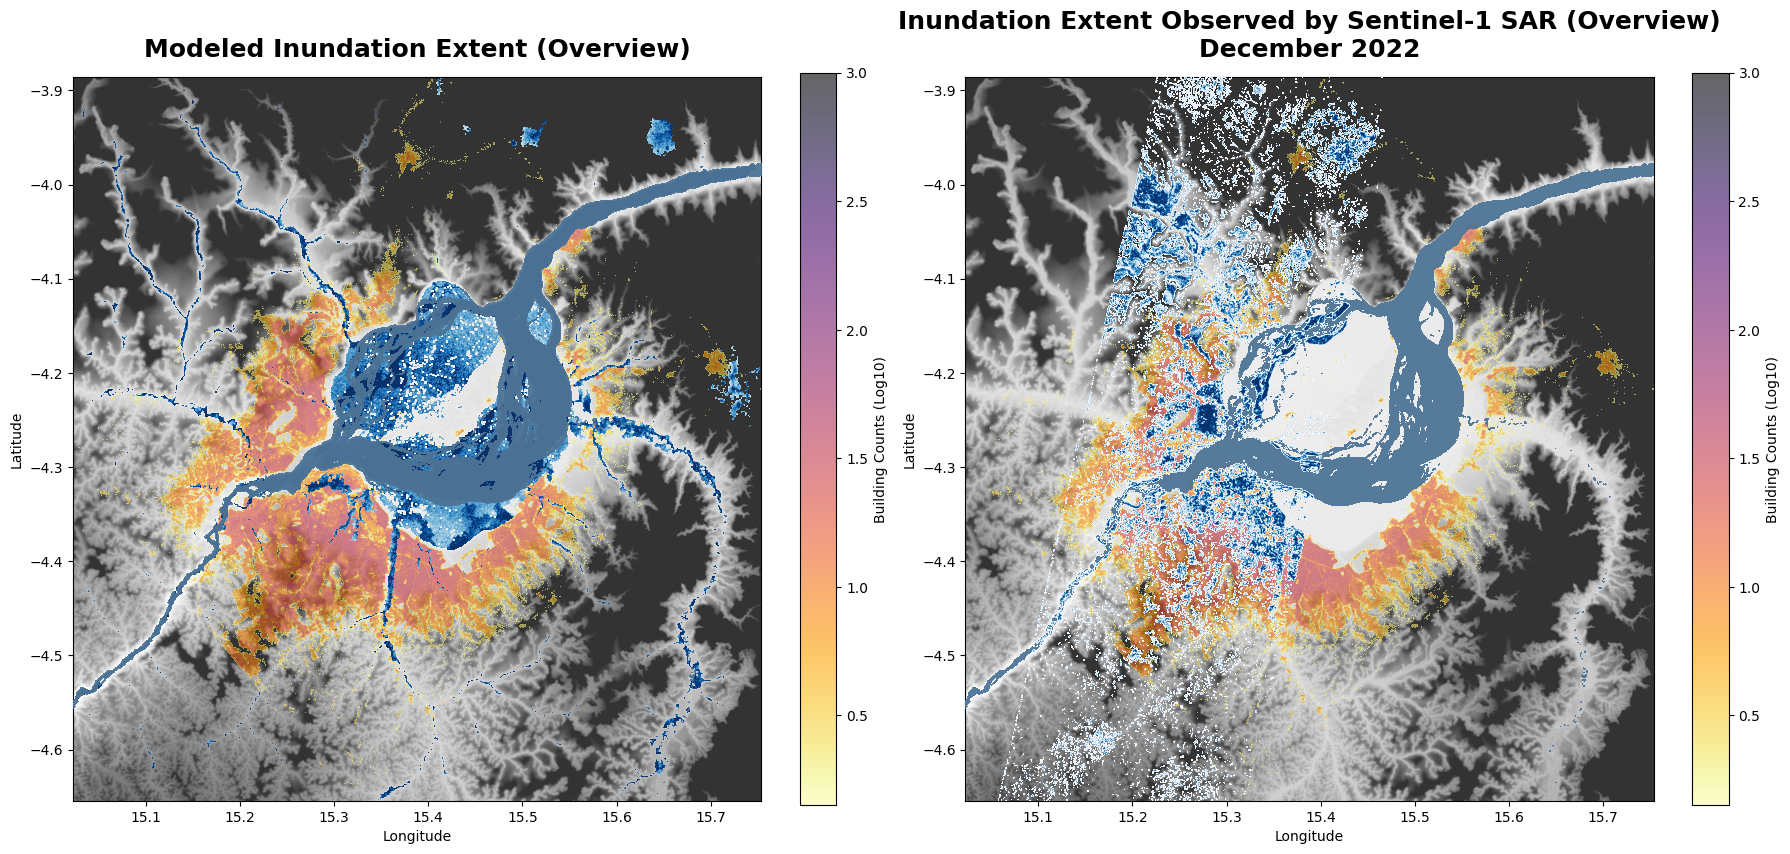

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(18,10), sharey=False, sharex=False)

# plot DEM as background
dem_view = pysh_grid.view(pysh_dem, nodata=np.nan)
ax[0].imshow(dem_view, extent=pysh_grid.extent,
             cmap='Greys', zorder=1, vmax = 500, alpha = 0.8)

# set properties so that building densities under the limits are transparent
pop_cmap = cm.inferno_r
pop_cmap.set_under('k', alpha=0)

# plot building density as visual information
p = ax[0].imshow(drc_building_density, extent=pysh_grid.extent,
                 cmap=pop_cmap, clim=[0.15, 3], zorder=2, alpha=0.6)

# plot inundation extent
ax[0].imshow(pysh_inundation_extent, extent=pysh_grid.extent,
           cmap='Blues', vmin=0, vmax=10, zorder=3)


ax[0].set_title(f'Modeled Inundation Extent (Overview)',
                size=18, fontweight = "bold", pad = 15)

plt.colorbar(p, ax = ax[0], fraction = 0.048,
             label = "Building Counts (Log10)")

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')


# --------------------------------------------
# plot DEM as background
ax[1].imshow(dem_view, extent=pysh_grid.extent,
             cmap='Greys', zorder=1, vmax = 500, alpha = 0.8)

# set properties so that building densities under the limits are transparent
pop_cmap = cm.inferno_r
pop_cmap.set_under('k', alpha=0)

# plot building density as visual information
p = ax[1].imshow(drc_building_density, extent=pysh_grid.extent,
                 cmap=pop_cmap, clim=[0.15, 3], zorder=2, alpha=0.6)

# read in flooded tif as an array
sar_extent = plt.imread("/content/drive/MyDrive/SAR_flooded.tif")

# set properties so that non flooded areas are transparent
sar_cmap = cm.Blues
sar_cmap.set_under('k', alpha=0)

# plot SAR flooded areas
ax[1].imshow(sar_extent, extent=pysh_grid.extent,
           cmap=sar_cmap, clim=[0.01, 1], zorder=4)

ax[1].set_title('Inundation Extent Observed by Sentinel-1 SAR (Overview)\nDecember 2022',
                size=18, fontweight = "bold", pad = 15)

plt.colorbar(p, ax = ax[1], fraction = 0.048,
             label = "Building Counts (Log10)")

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')


# -----------------------------------------------
# plot where the seasonal water flows (to be comparable visually to pysheds plot
# since our SAR image does not cover the whole area)

swater_cmap = cm.colors.ListedColormap(['xkcd:cadet blue'])
swater_cmap.set_under('k', alpha=0)

ax[0].imshow(swater_np, extent=pysh_grid.extent,
           cmap=swater_cmap, clim=[0.01, 1], zorder=3, alpha = 0.95)
ax[1].imshow(swater_np, extent=pysh_grid.extent,
           cmap=swater_cmap, clim=[0.01, 1], zorder=3, alpha = 0.95)

plt.tight_layout()



# plt.savefig("side_by_side_overview", format = "png", dpi = 200)

### Kinshasa

#### Population Density (Open Buildings)

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

Download buildings data for a region in Africa [takes up to 15 minutes for large countries]

In [ ]:
#@markdown Select a region from either the [Natural Earth low res](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) (fastest), [Natural Earth high res](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) or [World Bank high res](https://datacatalog.worldbank.org/dataset/world-bank-official-boundaries) shapefiles:
region_border_source = 'Natural Earth (High Res 10m)'  #@param ["Natural Earth (Low Res 110m)", "Natural Earth (High Res 10m)", "World Bank (High Res 10m)"]
region = ''  #@param ["", "AGO (Angola)", "BDI (Burundi)", "BEN (Benin)", "BFA (Burkina Faso)", "BGD (Bangladesh)", "BRN (Brunei)", "BTN (Bhutan)", "BWA (Botswana)", "CAF (Central African Republic)", "CIV (C\u00f4te d'Ivoire)", "CMR (Cameroon)", "COD (Democratic Republic of the Congo)", "COG (Republic of the Congo)", "COM (Comoros)", "CPV (Cape Verde)", "DJI (Djibouti)", "DZA (Algeria)", "EGY (Egypt)", "ERI (Eritrea)", "ETH (Ethiopia)", "GAB (Gabon)", "GHA (Ghana)", "GIN (Guinea)", "GMB (The Gambia)", "GNB (Guinea-Bissau)", "GNQ (Equatorial Guinea)", "IDN (Indonesia)", "IOT (British Indian Ocean Territory)", "KEN (Kenya)", "KHM (Cambodia)", "LAO (Laos)", "LBR (Liberia)", "LKA (Sri Lanka)", "LSO (Lesotho)", "MDG (Madagascar)", "MDV (Maldives)", "MOZ (Mozambique)", "MRT (Mauritania)", "MUS (Mauritius)", "MWI (Malawi)", "MYS (Malaysia)", "MYT (Mayotte)", "NAM (Namibia)", "NER (Niger)", "NGA (Nigeria)", "NPL (Nepal)", "PHL (Philippines)", "REU (R\u00e9union)", "RWA (Rwanda)", "SDN (Sudan)", "SEN (Senegal)", "SGP (Singapore)", "SHN (Saint Helena, Ascension and Tristan da Cunha)", "SLE (Sierra Leone)", "SOM (Somalia)", "STP (S\u00e3o Tom\u00e9 and Pr\u00edncipe)", "SWZ (Eswatini)", "SYC (Seychelles)", "TGO (Togo)", "THA (Thailand)", "TLS (Timor-Leste)", "TUN (Tunisia)", "TZA (Tanzania)", "UGA (Uganda)", "VNM (Vietnam)", "ZAF (South Africa)", "ZMB (Zambia)", "ZWE (Zimbabwe)"]

#@markdown Alternatively, specify an area of interest in [WKT format](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (assumes crs='EPSG:4326'); this [tool](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) might be useful.
your_own_wkt_polygon = 'POLYGON((15.16696 -4.40049, 15.16696 -4.19645, 15.37276 -4.19645, 15.37261 -4.40049, 15.16696 -4.40049))'  #@param {type:"string"}
#@markdown Select type of data to download here:
data_type = 'points'  #@param ["polygons", "points"]
#@markdown In this analysis we only need centroids of buildings, therefore by default we use the data in the *point* format (files in *polygons* format are larger). Refer to [Open Buildings Data Format](https://sites.research.google/open-buildings/#dataformat) for more details.
!sudo apt-get install swig
!pip install -q s2geometry pygeos geopandas

import functools
import glob
import gzip
import multiprocessing
import os
import shutil
import tempfile
from typing import List, Optional, Tuple


import geopandas as gpd
from google.colab import files
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s2geometry as s2
import shapely
import tensorflow as tf
import tqdm.notebook

BUILDING_DOWNLOAD_PATH = ('gs://open-buildings-data/v3/'
                          f'{data_type}_s2_level_6_gzip_no_header')

def get_filename_and_region_dataframe(
    region_border_source: str, region: str,
    your_own_wkt_polygon: str) -> Tuple[str, gpd.geodataframe.GeoDataFrame]:
  """Returns output filename and a geopandas dataframe with one region row."""

  if your_own_wkt_polygon:
    filename = f'open_buildings_v3_{data_type}_your_own_wkt_polygon.csv.gz'
    region_df = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt([your_own_wkt_polygon]),
        crs='EPSG:4326')
    if not isinstance(region_df.iloc[0].geometry,
                      shapely.geometry.polygon.Polygon) and not isinstance(
                          region_df.iloc[0].geometry,
                          shapely.geometry.multipolygon.MultiPolygon):
      raise ValueError("`your_own_wkt_polygon` must be a POLYGON or "
                      "MULTIPOLYGON.")
    print(f'Preparing your_own_wkt_polygon.')
    return filename, region_df

  if not region:
    raise ValueError('Please select a region or set your_own_wkt_polygon.')

  if region_border_source == 'Natural Earth (Low Res 110m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/110m/cultural/ne_110m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_110m'
  elif region_border_source == 'Natural Earth (High Res 10m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/10m/cultural/ne_10m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_10m'
  elif region_border_source == 'World Bank (High Res 10m)':
    url = ('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/'
           '779551/wb_countries_admin0_10m.zip')
    !wget -N {url}
    !unzip -o {os.path.basename(url)}
    display.clear_output()
    region_shapefile_path = 'WB_countries_Admin0_10m'
    source_name = 'wb_10m'

  region_iso_a3 = region.split(' ')[0]
  filename = (f'open_buildings_v3_{data_type}_'
              f'{source_name}_{region_iso_a3}.csv.gz')
  region_df = gpd.read_file(region_shapefile_path).query(
      f'ISO_A3 == "{region_iso_a3}"').dissolve(by='ISO_A3')[['geometry']]
  print(f'Preparing {region} from {region_border_source}.')
  return filename, region_df


def get_bounding_box_s2_covering_tokens(
    region_geometry: shapely.geometry.base.BaseGeometry) -> List[str]:
  region_bounds = region_geometry.bounds
  s2_lat_lng_rect = s2.S2LatLngRect_FromPointPair(
      s2.S2LatLng_FromDegrees(region_bounds[1], region_bounds[0]),
      s2.S2LatLng_FromDegrees(region_bounds[3], region_bounds[2]))
  coverer = s2.S2RegionCoverer()
  # NOTE: Should be kept in-sync with s2 level in BUILDING_DOWNLOAD_PATH.
  coverer.set_fixed_level(6)
  coverer.set_max_cells(1000000)
  return [cell.ToToken() for cell in coverer.GetCovering(s2_lat_lng_rect)]


def s2_token_to_shapely_polygon(
    s2_token: str) -> shapely.geometry.polygon.Polygon:
  s2_cell = s2.S2Cell(s2.S2CellId_FromToken(s2_token, len(s2_token)))
  coords = []
  for i in range(4):
    s2_lat_lng = s2.S2LatLng(s2_cell.GetVertex(i))
    coords.append((s2_lat_lng.lng().degrees(), s2_lat_lng.lat().degrees()))
  return shapely.geometry.Polygon(coords)


def download_s2_token(
    s2_token: str, region_df: gpd.geodataframe.GeoDataFrame) -> Optional[str]:
  """Downloads the matching CSV file with polygons for the `s2_token`.

  NOTE: Only polygons inside the region are kept.
  NOTE: Passing output via a temporary file to reduce memory usage.

  Args:
    s2_token: S2 token for which to download the CSV file with building
      polygons. The S2 token should be at the same level as the files in
      BUILDING_DOWNLOAD_PATH.
    region_df: A geopandas dataframe with only one row that contains the region
      for which to keep polygons.

  Returns:
    Either filepath which contains a gzipped CSV without header for the
    `s2_token` subfiltered to only contain building polygons inside the region
    or None which means that there were no polygons inside the region for this
    `s2_token`.
  """
  s2_cell_geometry = s2_token_to_shapely_polygon(s2_token)
  region_geometry = region_df.iloc[0].geometry
  prepared_region_geometry = shapely.prepared.prep(region_geometry)
  # If the s2 cell doesn't intersect the country geometry at all then we can
  # know that all rows would be dropped so instead we can just return early.
  if not prepared_region_geometry.intersects(s2_cell_geometry):
    return None
  try:
    # Using tf.io.gfile.GFile gives better performance than passing the GCS path
    # directly to pd.read_csv.
    with tf.io.gfile.GFile(
        os.path.join(BUILDING_DOWNLOAD_PATH, f'{s2_token}_buildings.csv.gz'),
        'rb') as gf:
      # If the s2 cell is fully covered by country geometry then can skip
      # filtering as we need all rows.
      if prepared_region_geometry.covers(s2_cell_geometry):
        with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as tmp_f:
          shutil.copyfileobj(gf, tmp_f)
          return tmp_f.name
      # Else take the slow path.
      # NOTE: We read in chunks to save memory.
      csv_chunks = pd.read_csv(
          gf, chunksize=2000000, dtype=object, compression='gzip', header=None)
      tmp_f = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
      tmp_f.close()
      for csv_chunk in csv_chunks:
        points = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(csv_chunk[1], csv_chunk[0]),
            crs='EPSG:4326')
        # sjoin 'within' was faster than using shapely's 'within' directly.
        points = gpd.sjoin(points, region_df, predicate='within')
        csv_chunk = csv_chunk.iloc[points.index]
        csv_chunk.to_csv(
            tmp_f.name,
            mode='ab',
            index=False,
            header=False,
            compression={
                'method': 'gzip',
                'compresslevel': 1
            })
      return tmp_f.name
  except tf.errors.NotFoundError:
    return None

# Clear output after pip install.
display.clear_output()
filename, region_df = get_filename_and_region_dataframe(region_border_source,
                                                        region,
                                                        your_own_wkt_polygon)
# Remove any old outputs to not run out of disk.
for f in glob.glob('/tmp/open_buildings_*'):
  os.remove(f)
# Write header to the compressed CSV file.
with gzip.open(f'/tmp/{filename}', 'wt') as merged:
  if data_type == "polygons":
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence', 'geometry',
        'full_plus_code'
    ]) + '\n')
  else:
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence',
        'full_plus_code'
    ]) + '\n')
download_s2_token_fn = functools.partial(download_s2_token, region_df=region_df)
s2_tokens = get_bounding_box_s2_covering_tokens(region_df.iloc[0].geometry)
# Downloads CSV files for relevant S2 tokens and after filtering appends them
# to the compressed output CSV file. Relies on the fact that concatenating
# gzipped files produces a valid gzip file.
# NOTE: Uses a pool to speed up output preparation.
with open(f'/tmp/{filename}', 'ab') as merged:
  with multiprocessing.Pool(4) as e:
    for fname in tqdm.notebook.tqdm(
        e.imap_unordered(download_s2_token_fn, s2_tokens),
        total=len(s2_tokens)):
      if fname:
        with open(fname, 'rb') as tmp_f:
          shutil.copyfileobj(tmp_f, merged)
        os.unlink(fname)

Preparing your_own_wkt_polygon.


  0%|          | 0/1 [00:00<?, ?it/s]

**Visualise the data**

First we convert the CSV file into a GeoDataFrame. The CSV files can be quite large when they include the polygon outline of every building, that is, when the data type downloaded is polygons. For this example we only need longitude and latitude, so we only process those columns to save memory.

In [ ]:
buildings = pd.read_csv(
    f"/tmp/{filename}", engine="c",
    usecols=['latitude', 'longitude', 'area_in_meters', 'confidence'])

print(f"Read {len(buildings):,} records.")

Read 999,156 records.


For some countries there can be tens of millions of buildings, so we also take a random sample for doing plots.

In [ ]:
sample_size = 400000  #@param

In [ ]:
buildings_sample = (buildings.sample(sample_size)
                    if len(buildings) > sample_size else buildings)

Prepare the data for mapping building statistics

Set up a grid, which we will use to calculate statistics about buildings.

We also want to select the examples most likely to be buildings, using a threshold on the confidence score.

In [ ]:
max_grid_dimension = 1000 #@param
confidence_threshold = 0.75 #@param

In [ ]:
buildings = buildings.query(f"confidence > {confidence_threshold}")

In [ ]:
# Create a grid covering the dataset bounds
min_lon = buildings.longitude.min()
max_lon = buildings.longitude.max()
min_lat = buildings.latitude.min()
max_lat = buildings.latitude.max()

grid_density_degrees = (max(max_lon - min_lon, max_lat - min_lat)
                        / max_grid_dimension)

bounds = [min_lon, min_lat, max_lon, max_lat]
xcoords = np.arange(min_lon, max_lon, grid_density_degrees)
ycoords = np.arange(max_lat, min_lat, -grid_density_degrees)
xv, yv = np.meshgrid(xcoords, ycoords)
xy = np.stack([xv.ravel(), yv.ravel()]).transpose()

print(f"Calculated grid of size {xv.shape[0]} x {xv.shape[1]}.")

Calculated grid of size 992 x 1000.


To calculate statistics, we need a function to convert between (longitude, latitude) coordinates in the world and (x, y) coordinates in the grid.

In [ ]:
geotransform = (min_lon, grid_density_degrees, 0,
                max_lat, 0, -grid_density_degrees)

def lonlat_to_xy(lon, lat, geotransform):
    x = int((lon - geotransform[0])/geotransform[1])
    y = int((lat - geotransform[3])/geotransform[5])
    return x,y

Now we can count how many buildings there are on each cell of the grid.

In [ ]:
counts = np.zeros(xv.shape)
area_totals = np.zeros(xv.shape)

for lat, lon, area in tqdm.notebook.tqdm(
    zip(buildings.latitude, buildings.longitude, buildings.area_in_meters)):
  x, y = lonlat_to_xy(lon, lat, geotransform)
  if x >= 0 and y >= 0 and x < len(xcoords) and y < len(ycoords):
    counts[y, x] += 1
    area_totals[y, x] += area

area_totals[counts == 0] = np.nan
counts[counts == 0] = np.nan
mean_area = area_totals / counts

0it [00:00, ?it/s]

In [ ]:
# cropping pysheds to kinshasa

longitude_top_left = 15.16696
longitude_top_right = 15.37276
latitude_bottom_left = -4.40049
latitude_top_left = -4.19645

ksh_extent = [longitude_top_left, longitude_top_right, latitude_bottom_left, latitude_top_left]

# LEAVE THESE ALONE
pysh_cropped = pysh_masked_flooded[1175:1950, 490:1200]
dem_crop = pysh_dem[1140:1890, 470:1175]

#### Kinshasa Maps

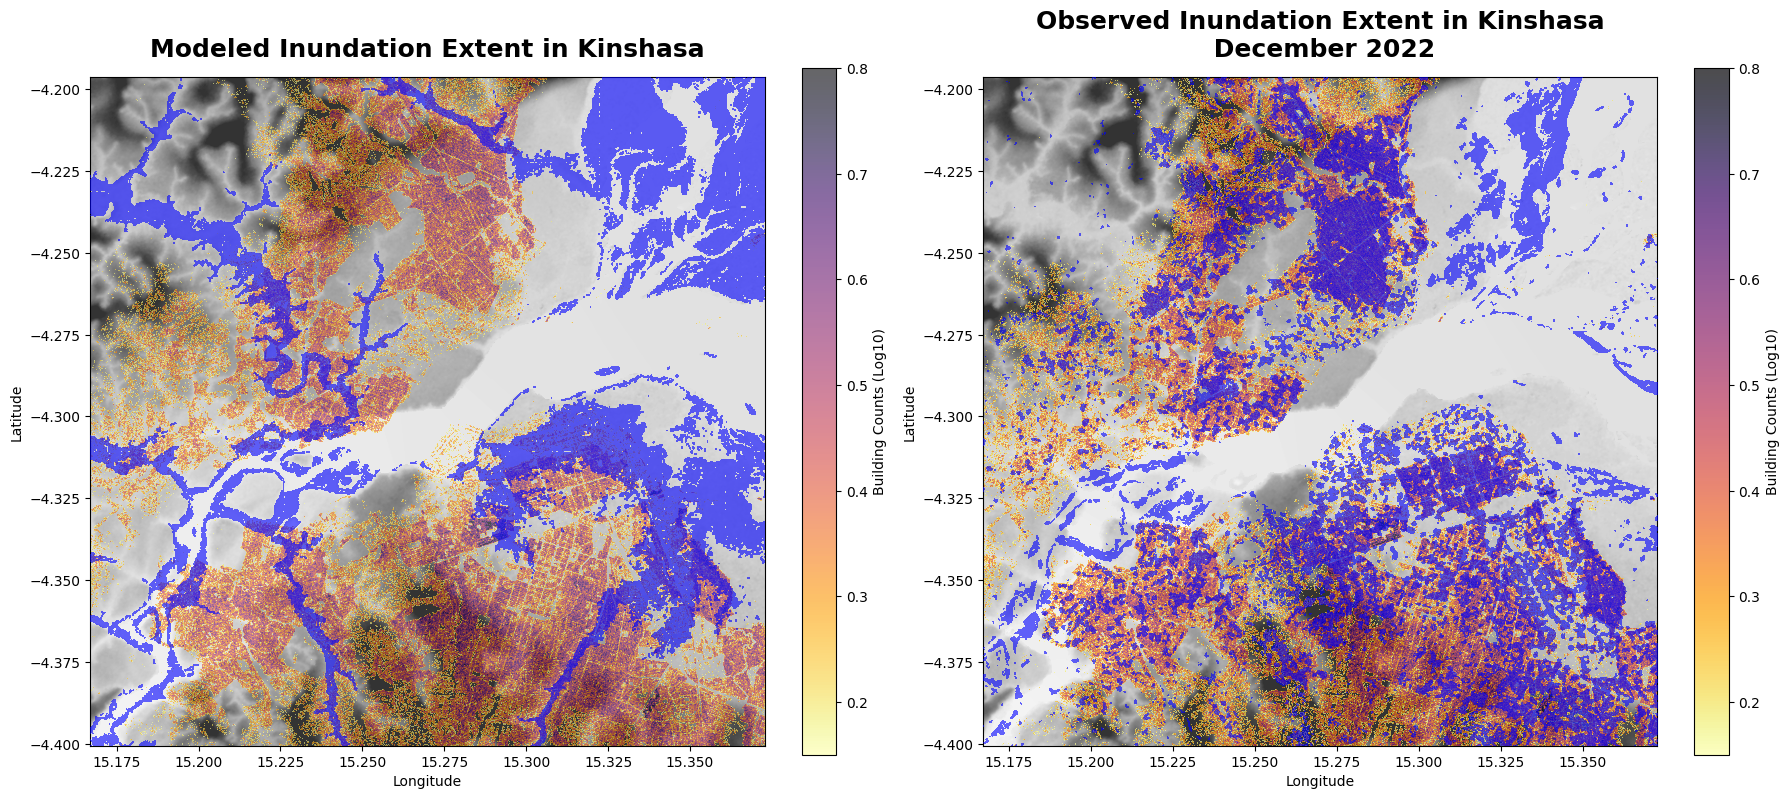

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(18,10))

ax[0].imshow(dem_crop, extent=ksh_extent, cmap='Greys', zorder=1,  vmax=400, alpha = 0.8)

pop_cmap = cm.inferno_r
pop_cmap.set_under('k', alpha=0)

p = ax[0].imshow((np.log10(np.nan_to_num(counts) + 1.)), extent=ksh_extent, cmap=pop_cmap, clim=[0.15, 0.8], zorder=2, alpha=0.6)

pysh_cmap = cm.colors.ListedColormap(['blue'])
pysh_cmap.set_under('k', alpha=0)

ax[0].imshow(pysh_cropped, extent=ksh_extent,
           cmap=pysh_cmap, clim=[0.01, 1], zorder=3, alpha = 0.6)

ax[0].set_title(f'Modeled Inundation Extent in Kinshasa', size=18, fontweight = "bold", pad = 15)

plt.colorbar(p, ax=ax[0], fraction = 0.046, label = "Building Counts (Log10)")
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')





ax[1].imshow(dem_crop, extent=ksh_extent, cmap='Greys', zorder=1,  vmax=400, alpha = 0.8)

pop_cmap = cm.inferno_r
pop_cmap.set_under('k', alpha=0)

p = ax[1].imshow((np.log10(np.nan_to_num(counts) + 1.)), extent=ksh_extent,  cmap=pop_cmap, clim=[0.15, 0.8], zorder=2, alpha=0.7)

ksh_sar_extent = plt.imread("/content/drive/MyDrive/ksh_SAR_flooded.tif")

sar_cmap = cm.colors.ListedColormap(['blue'])
sar_cmap.set_under('k', alpha=0)

ax[1].imshow(ksh_sar_extent, extent=ksh_extent,
           cmap=sar_cmap, clim=[0.1, 1], zorder=4, alpha = 0.6)


ax[1].set_title(f'Observed Inundation Extent in Kinshasa\n December 2022', size=18, fontweight = "bold", pad = 15)

plt.colorbar(p, ax=ax[1], fraction = 0.046, label = "Building Counts (Log10)")


ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.tight_layout()

# plt.savefig("side_by_side_kinshasa", format = "png", dpi = 200)

#### Kinshasa Flood Extent Comparison

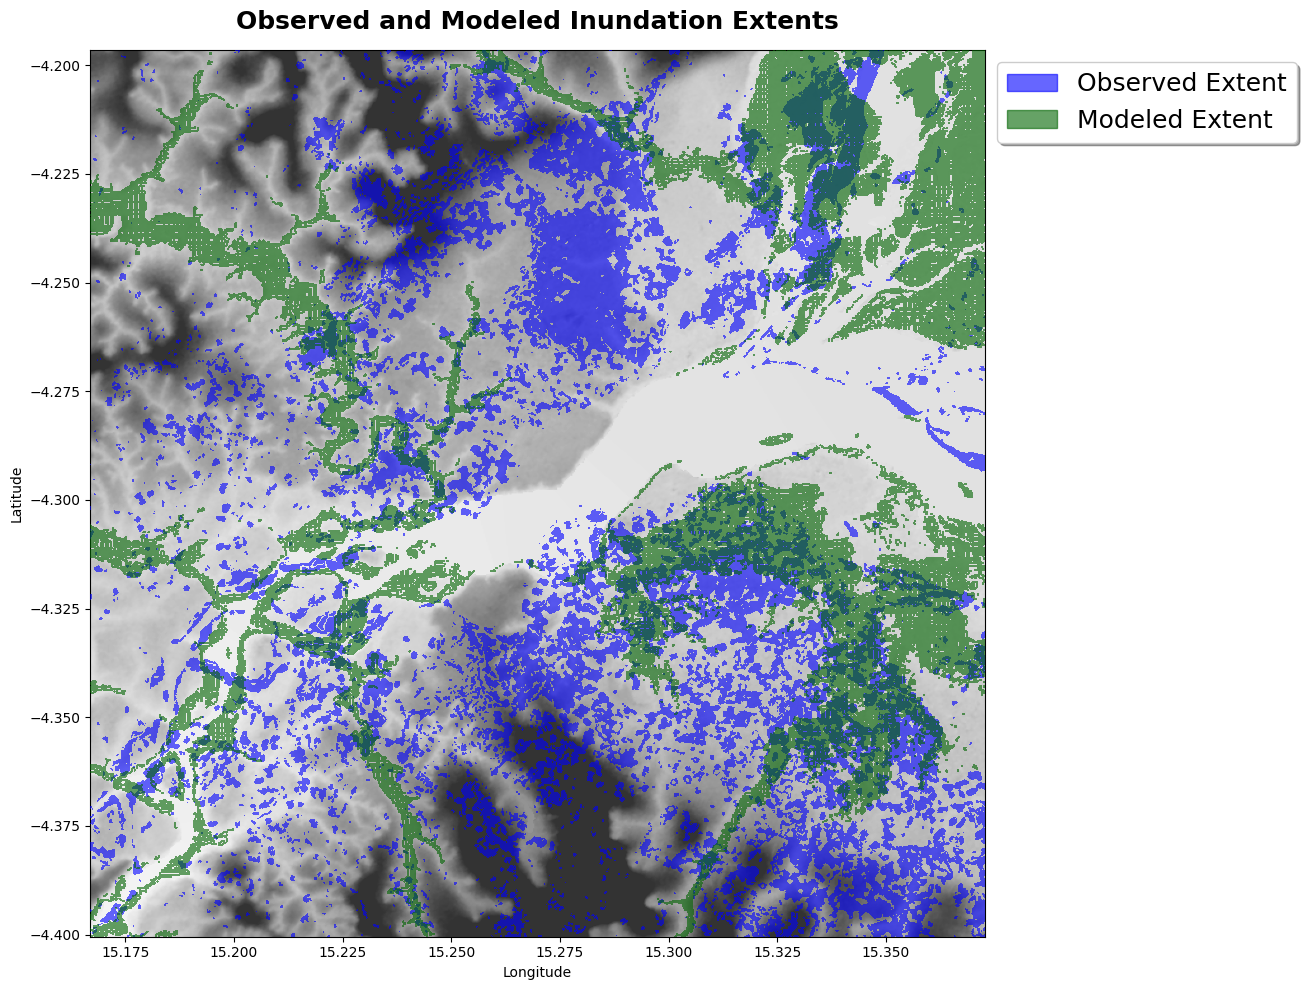

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

plt.imshow(dem_crop, extent=ksh_extent, cmap='Greys', zorder=1,  vmax=400, alpha = 0.8)

ksh_sar_extent = plt.imread("/content/drive/MyDrive/ksh_SAR_flooded.tif")

sar_cmap = cm.colors.ListedColormap(['blue'])
sar_cmap.set_under('k', alpha=0)

plt.imshow(ksh_sar_extent, extent=ksh_extent,
           cmap=sar_cmap, clim=[0.1, 1], zorder=4, alpha = 0.6)

pysh_cmap = cm.colors.ListedColormap(['darkgreen'])
pysh_cmap.set_under('k', alpha=0)

plt.imshow(pysh_cropped, extent=ksh_extent,
           cmap=pysh_cmap, clim=[0.01, 1], zorder=5, alpha = 0.6)

# Create legend patches for blue and green
blue_patch = mpatches.Patch(color='blue', label='Observed Extent', alpha = 0.6)
green_patch = mpatches.Patch(color='darkgreen', label='Modeled Extent', alpha = 0.6)

# Combine the legend patches
legend_patches = [blue_patch, green_patch]

# Add the legend to the plot
plt.legend(handles=legend_patches,
           loc='upper left',
           frameon=True,
           facecolor = "white",
           fontsize = 18,
           fancybox=True,
           shadow=True,
           bbox_to_anchor = (1,1))
          #  borderaxespad=2)


plt.title(f'Observed and Modeled Inundation Extents', size=18, fontweight = "bold", pad = 15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# plt.savefig("kinshasa_extents_compared", format = "png", dpi = 200, bbox_inches="tight")

## Precipitation (NCEI NOAA API)
This couldn't actually be directly used in our model but we wrote this code before discovering that and would still like to include it (it is where we got the rainfall amount used in the report)

In [ ]:
!pip install -q mapclassify

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import mapclassify
import geopandas as gpd
import requests # is whats used to access data from web

In [ ]:
# import requests #is whats used to access data from web
# import pandas as pd #dont actually need
# import numpy as np #dont actually need
"""This is code that is (quite a bit) modified from a code that was provided to
Rayne by proffesor Allison Pfeiffer during her undergrad. This code isn't
directly on her github, but this is as close as i can get to citing her
https://github.com/pfeiffea"""


location_id = "FIPS:CG"

datasets = "daily-summaries" # dataset to query for data (daily summaries, global summaries, etc)

station_id = "CF000004450" # comma separated list of station identifiers for selection and subsetting
# got this from searching kinshasa weather stations with daily summaries on ncei interactive website

start_date = "2022-12-11" # YYYY-MM-DD
end_date = "2022-12-15" # YYYY-MM-DD
data_format = "csv" # how the returned data should be formatted (csv, ssv, json, pdf, netcdf)
units = "metric" # units of returned data (if conversion is needed)
bounding_box = "-1.08739,14.78575,-4.72939,17.93219" # N,W,S,E - select data from a geographic location contained within the coordinates range (-90 to 90) to (-180 to 180)
data_type = "PRCP"

url = ('https://www.ncei.noaa.gov/access/services/data/v1?dataset='
       + datasets
       + "&startDate="
       + start_date
       + "&endDate="
       + end_date
       + "&dataTypes="
       + data_format
       + "&format="
       + data_format
       + "&units="
       + units
       + "&stations="
       + station_id
       + "&dataTypes="
       + data_type
       + "&includeStationName=true&includeStationLocation=1"
       )


response = requests.get(url)
# asking python to get that url info

data = response.text
# naming everything from that site as 'data'


# %% Second, we're going to save as a textfile

filename = "DRC_Kinshasa_Precip_" + start_date +'_'+end_date+".csv"


# We want to save the text files into the same directory as this .py script, so
# we need to import the operating system module
import os

path=os.path.join( os.getcwd(), filename)
# get current working directory

file=open(path, 'w')
# print(path)

file.write(data)
# write in that file 'data'

file.close()

In [ ]:
rainfall = gpd.read_file("DRC_Kinshasa_Precip_2022-12-11_2022-12-15.csv")

In [ ]:
rainfall_proj = gpd.points_from_xy(rainfall.LONGITUDE, rainfall.LATITUDE)
rain = gpd.GeoDataFrame(rainfall, geometry = rainfall_proj, crs = "EPSG:4326")

In [ ]:
# making sure it's at the right location

rain.explore()

In [ ]:
# getting how much it rained (i know the max is from the day
# of the flood from looking at the dataframe)

max_rain = max(rain["PRCP"])
max_rain

'84.1'